# Intro ML Homework 6
## Name: Jaskin Kabir
## Student ID: 801186717
Github: https://github.com/jaskinkabir/Intro_ML/tree/main/HM5

In [63]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn

path = 'housing.csv'
housing = pd.DataFrame(pd.read_csv(path))

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

df_train, df_test = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

Y_train_tensor_p1 = df_train.pop('price')
X_train = df_train

Y_test_tensor_p1 = df_test.pop('price')
X_test_batch = df_test
X_train.head()


b_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X_p3 = housing[b_vars]
X_train_df_p3 = X_train[b_vars]
X_test_df_p3 = X_test_batch[b_vars]

X_train_tensor_p1 = X_train_df_p3.to_numpy()
X_test_tensor_p1 = X_test_df_p3.to_numpy()

scaler = preprocessing.StandardScaler().fit(X_train_tensor_p1)
X_train_tensor_p1 = scaler.transform(X_train_tensor_p1)
X_test_tensor_p1 = scaler.transform(X_test_tensor_p1)




In [64]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

class Regressor(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print(100 * (results1 - results2) / results1)
        
    def __init__(self, in_dim, out_dim, hidden_layers=[64,32], activation=nn.Tanh,):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.input_cols = []
        self.output_cols = []
        
        #Error Mode is a 5 bit integer, with each bit representing a feature
        # If the bit is 1, the feature is errored
        output_features = out_dim
        input_features = in_dim
        

        
        self.stack_list = [nn.Linear(input_features, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])
        self.stack_list.extend([nn.Linear(hidden_layers[-1], output_features)])
        self.stack = nn.Sequential(*self.stack_list)
        
        
        
    def train(self, epochs, X_train, X_test, Y_train, Y_test, alpha=1e-2, loss_fn=nn.MSELoss(),):
        
        val_hist = np.zeros(epochs)
        train_hist = np.zeros(epochs)

        optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        for i in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred.squeeze(), Y_train)
            loss.backward()
            optimizer.step()
            train_hist[i] = np.sqrt(loss.item())
            
            
            with torch.no_grad():
                Y_pred_val = self.forward(X_test)
                val_hist[i] = np.sqrt(loss_fn(Y_pred_val, Y_test).item())
            
        self.last_test = Y_test_tensor_p1
        self.last_pred = self.forward(X_test)
        self.last_score = val_hist[-1]
        
        self.last_epochs = epochs
        self.last_val_hist = val_hist
        self.last_train_hist = train_hist
    
    def plot_loss(self, title):
        
        plt.plot(range(self.last_epochs), self.last_val_hist, label='Validation Loss')
        plt.plot(range(self.last_epochs), self.last_train_hist, label='Training Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('RMS Loss')
        plt.legend()
        plt.show()
        
    def forward(self, x):
        return self.stack(x)
    
    def print_results(self):
        if self.last_score is None:
            raise ValueError('No results to print')
        print(f'MSE: {self.last_score:.2E}')
        
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_val=0.0):
        super(CustomMSELoss, self).__init__()
        self.lambda_val = lambda_val
    
    def forward(self, predictions, targets):

        m = targets.size(0)
        
        errors = predictions - targets
        mse_loss = (1 / (2*m)) * torch.sum(errors ** 2)
        

        

        total_loss = mse_loss
        
        return total_loss

/home/jaskin/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([436, 1])) that is different to the input size (torch.Size([436])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


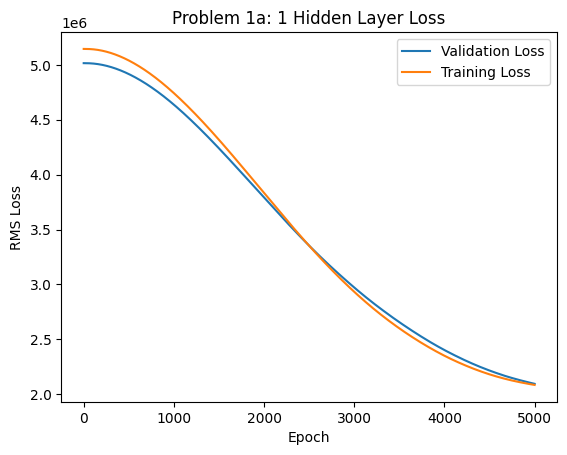

MSE: 2.09E+06


In [65]:
device = 'cpu'


X_train_tensor_p1 = torch.tensor(X_train_tensor_p1).to(device).float()
X_test_tensor_p1 = torch.tensor(X_test_tensor_p1).to(device).float()

Y_train_tensor_p1 = torch.tensor(Y_train_tensor_p1.to_numpy()).to(device).float().view(-1, 1)
Y_test_tensor_p1 = torch.tensor(Y_test_tensor_p1.to_numpy()).to(device).float().view(-1, 1)


model_1a = Regressor(
    in_dim=X_train_tensor_p1.shape[1],
    out_dim=1,
    hidden_layers=[8],
    activation=nn.ReLU,
).to(device)

model_1a.train(
    epochs=5000,
    X_train=X_train_tensor_p1,
    X_test=X_test_tensor_p1,
    Y_train=Y_train_tensor_p1,
    Y_test=Y_test_tensor_p1,
    alpha=1e-1,
    loss_fn=nn.MSELoss(),
)

model_1a.plot_loss('Problem 1a: 1 Hidden Layer Loss')
model_1a.print_results()

In [67]:
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()
X_2 = breast.data
Y_2 = breast.target

X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2, Y_2, train_size=0.8, test_size=0.2, random_state=00)

scaler = preprocessing.StandardScaler().fit(X_train_2)
X_train_2 = scaler.transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_test, torch.Tensor):
            Y_test = Y_test.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred, average='weighted'),
            'recall': recall_score(Y_test, Y_pred, average='weighted'),
            'f1': f1_score(Y_test, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')
                
    
class LogisticClassifier(Classifier):        
    def __init__(self, input_dim=0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        if pass_through:
            return
        self.stack_list = [nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.extend([nn.Linear(hidden_layers[-1], 1), nn.Sigmoid()]) 
        self.stack = nn.Sequential(*self.stack_list)
        
    def forward(self, x):
        return self.stack(x)
    
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).round()
    
    def train(self, epochs, X_train, X_test, Y_train, Y_test, alpha, loss_fn=nn.BCELoss(), print_epoch=500):
        optimizer = torch.optim.SGD(self.parameters(), lr=alpha)

        for epoch in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred, Y_train)
            loss.backward()
            optimizer.step()
            if epoch % print_epoch == 0:
                test_loss = loss_fn(self.forward(X_test), Y_test)
                print(f'Epoch {epoch}: Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')
        Y_pred = self.predict(X_test)
        self.last_pred = Y_pred
        self.last_test = Y_test
        return [Y_test,Y_pred]
    


In [69]:
X_train_2 = torch.tensor(X_train_2).to(device).float()
X_test_2 = torch.tensor(X_test_2).to(device).float()
Y_train_2 = torch.tensor(Y_train_2).to(device).float().view(-1, 1)
Y_test_2 = torch.tensor(Y_test_2).to(device).float().view(-1, 1)

model_2a = LogisticClassifier(
    input_dim=X_train_2.shape[1],
    hidden_layers=[32],
    activation=nn.ReLU
).to(device)

model_2a.train(
    epochs=5000,
    X_train=X_train_2,
    X_test=X_test_2,
    Y_train=Y_train_2,
    Y_test=Y_test_2,
    alpha=1e-1,
    loss_fn=nn.BCELoss(),
    print_epoch=500
)

results_2a = model_2a.get_results()
model_2a.print_results(results_2a)

Epoch 0: Training Loss: 0.6775199174880981, Test Loss: 0.6508200168609619
Epoch 500: Training Loss: 0.05119786411523819, Test Loss: 0.08860453963279724
Epoch 1000: Training Loss: 0.03805161640048027, Test Loss: 0.09681770205497742
Epoch 1500: Training Loss: 0.029710467904806137, Test Loss: 0.10133590549230576
Epoch 2000: Training Loss: 0.023742537945508957, Test Loss: 0.09929131716489792
Epoch 2500: Training Loss: 0.018893906846642494, Test Loss: 0.09738191962242126
Epoch 3000: Training Loss: 0.015220258384943008, Test Loss: 0.09081994742155075
Epoch 3500: Training Loss: 0.012455631978809834, Test Loss: 0.08439692854881287
Epoch 4000: Training Loss: 0.010189911350607872, Test Loss: 0.07659681141376495
Epoch 4500: Training Loss: 0.008512535132467747, Test Loss: 0.06754373759031296
Accuracy: 0.9649122807017544
Precision: 0.9657164890247598
Recall: 0.9649122807017544
F1: 0.965011961722488
Confusion_matrix:
[[46  1]
 [ 3 64]]
Classification_report:
              precision    recall  f1-sco

In [70]:
model_2b = LogisticClassifier(
    input_dim=X_train_2.shape[1],
    hidden_layers=[32,64,32],
    activation=nn.ReLU
).to(device)

model_2b.train(
    epochs=5000,
    X_train=X_train_2,
    X_test=X_test_2,
    Y_train=Y_train_2,
    Y_test=Y_test_2,
    alpha=5e-2,
    loss_fn=nn.BCELoss(),
    print_epoch=500
)
print('\n')
results_2b = model_2b.get_results()
model_2b.print_results(results_2b)

Epoch 0: Training Loss: 0.7006031274795532, Test Loss: 0.6969746351242065
Epoch 500: Training Loss: 0.0444357804954052, Test Loss: 0.09696567803621292
Epoch 1000: Training Loss: 0.023338234052062035, Test Loss: 0.0965108647942543
Epoch 1500: Training Loss: 0.01155084278434515, Test Loss: 0.09876886010169983
Epoch 2000: Training Loss: 0.0062743364833295345, Test Loss: 0.1080765500664711
Epoch 2500: Training Loss: 0.0038169343024492264, Test Loss: 0.11713045835494995
Epoch 3000: Training Loss: 0.0025181507226079702, Test Loss: 0.12493595480918884
Epoch 3500: Training Loss: 0.0017743278294801712, Test Loss: 0.13145829737186432
Epoch 4000: Training Loss: 0.001317627727985382, Test Loss: 0.1369219720363617
Epoch 4500: Training Loss: 0.00102024688385427, Test Loss: 0.1416374146938324


Accuracy: 0.9473684210526315
Precision: 0.9502514456074828
Recall: 0.9473684210526315
F1: 0.9476328183095101
Confusion_matrix:
[[46  1]
 [ 5 62]]
Classification_report:
              precision    recall  f1-sc

In [71]:
# Import cifar-10 dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

device = 'cuda' if torch.cuda.is_available() else 'cpu'


Files already downloaded and verified


In [72]:
train_imgs = torch.stack([img for img, _ in cifar10], dim=3)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)
X_test_3 = torch.stack([img for img, _ in cifar10_test], dim=3).view(3, -1).to(device=device)
Y_test_3 = torch.tensor([label for _, label in cifar10_test]).to(device=device)




Files already downloaded and verified
Files already downloaded and verified


In [73]:
import time

class ImageClassifier(Classifier):
    def __init__(self, input_dim=0, output_dim = 0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        self.stack_list = [nn.Flatten(), nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.extend([nn.Linear(hidden_layers[-1], output_dim), nn.Softmax(dim=1)])
        self.stack = nn.Sequential(*self.stack_list)
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs,
        train_loader,
        test_loader,
        alpha,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        print_epoch=10,
    ):
        
        optimizer = optimizer(self.parameters(), lr=alpha)
        training_time = 0
        for epoch in range(epochs):
            self.train()
            
            start_time = time.time()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            training_time += time.time() - start_time
            
            
            self.eval()
            with torch.no_grad():
                test_loss = 0
                Y_pred_eval = []
                Y_test = []
                for X_test_batch, Y_test_batch in test_loader:
                    X_test_batch, Y_test_batch = X_test_batch.to(device), Y_test_batch.to(device)
                    
                    out = self.forward(X_test_batch)
                    test_loss += loss_fn(out, Y_test_batch).item()
                    Y_test.extend(Y_test_batch.cpu().detach().numpy())
                    Y_pred_eval.extend(out.argmax(dim=1).cpu().detach().numpy())
                
            accuracy = accuracy_score(Y_test, Y_pred_eval)
            if epoch % print_epoch == 0:
                print(f'Epoch {epoch}: Training Loss: {train_loss/len(train_loader)}, Test Loss: {test_loss/len(test_loader)}, Accuracy: {accuracy}')
        self.last_pred = torch.tensor(Y_pred_eval)
        self.last_test = torch.tensor(Y_test)
        print(f'\nTraining Time: {training_time} seconds\n')

            
            

In [74]:
device = 'cuda'
model_3a = ImageClassifier(
    input_dim=3*32*32,
    output_dim=10,
    hidden_layers=[256],
    activation=nn.Tanh
).to(device)

model_3a.train_model(
    epochs=100,
    train_loader=train_loader,
    test_loader=test_loader,
    alpha=1e-2,
    loss_fn=nn.CrossEntropyLoss(),
    print_epoch=1
)

model_3a.get_results()
model_3a.print_results()


Epoch 0: Training Loss: 2.201410284737492, Test Loss: 2.1488690786300952, Accuracy: 0.3354
Epoch 1: Training Loss: 2.1313129562855986, Test Loss: 2.115134690217911, Accuracy: 0.3624
Epoch 2: Training Loss: 2.1072356914315384, Test Loss: 2.097880730963057, Accuracy: 0.3769
Epoch 3: Training Loss: 2.0923693166364488, Test Loss: 2.086663885481039, Accuracy: 0.3865
Epoch 4: Training Loss: 2.08120296205706, Test Loss: 2.077612098614881, Accuracy: 0.3979
Epoch 5: Training Loss: 2.0715074409609255, Test Loss: 2.070352053945991, Accuracy: 0.4042
Epoch 6: Training Loss: 2.0632094161589736, Test Loss: 2.064615787973829, Accuracy: 0.4078
Epoch 7: Training Loss: 2.0561082657340846, Test Loss: 2.0597093469777685, Accuracy: 0.4105
Epoch 8: Training Loss: 2.0497846004298275, Test Loss: 2.054938104501955, Accuracy: 0.4137
Epoch 9: Training Loss: 2.0441966700127057, Test Loss: 2.0527782402220804, Accuracy: 0.415
Epoch 10: Training Loss: 2.0390897987748655, Test Loss: 2.048685533225916, Accuracy: 0.4202

In [75]:
model_3a_results = model_3a.get_results()
model_3a.print_results(model_3a_results)

Accuracy: 0.4742
Precision: 0.46611456870171314
Recall: 0.4742
F1: 0.4682781879764696
Confusion_matrix:
[[587  37  61  25  20  17  24  36 137  56]
 [ 34 561  26  39  21  23  41  38  77 140]
 [105  37 289  78 141  69 143  69  42  27]
 [ 37  37  93 271  65 163 149  61  42  82]
 [ 50  25 128  58 394  57 116 111  31  30]
 [ 29  28 100 156  80 348  92  84  50  33]
 [ 11  24  58  70 127  63 563  29  25  30]
 [ 45  37  54  50  85  76  42 518  25  68]
 [ 89  58  16  24  13  28  14  20 681  57]
 [ 64 158  15  28  16  26  49  42  72 530]]
Classification_report:
              precision    recall  f1-score   support

           0       0.56      0.59      0.57      1000
           1       0.56      0.56      0.56      1000
           2       0.34      0.29      0.31      1000
           3       0.34      0.27      0.30      1000
           4       0.41      0.39      0.40      1000
           5       0.40      0.35      0.37      1000
           6       0.46      0.56      0.50      1000
         

Noticed the SGD optimizer is much slower than Adam, but yields more consistent results. To improve the model performance, the alpha was increased to 1e-2 to deal with the lower learning rate of SGD

In [76]:
device = 'cuda'
model_3b = ImageClassifier(
    input_dim=3*32*32,
    output_dim=10,
    hidden_layers=[256,512,128],#[256,384,256],
    activation=nn.Tanh
).to(device)

model_3b.train_model(
    epochs=100,
    train_loader=train_loader,
    test_loader=test_loader,
    alpha=1e-2,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    print_epoch=1
)

model_3b_results = model_3a.get_results()
model_3b.print_results(model_3a_results)

Epoch 0: Training Loss: 2.280403497273965, Test Loss: 2.252564680804113, Accuracy: 0.2359
Epoch 1: Training Loss: 2.228228701045141, Test Loss: 2.202385954036834, Accuracy: 0.2707
Epoch 2: Training Loss: 2.1879612088508313, Test Loss: 2.172818032039958, Accuracy: 0.2915
Epoch 3: Training Loss: 2.164266648804745, Test Loss: 2.152656055559778, Accuracy: 0.316
Epoch 4: Training Loss: 2.145001944983402, Test Loss: 2.1356226805668728, Accuracy: 0.3354
Epoch 5: Training Loss: 2.128756971615355, Test Loss: 2.1195827631434057, Accuracy: 0.3519
Epoch 6: Training Loss: 2.113841903484081, Test Loss: 2.107796171668229, Accuracy: 0.3608
Epoch 7: Training Loss: 2.1028579657949753, Test Loss: 2.098387276291088, Accuracy: 0.371
Epoch 8: Training Loss: 2.0934950303848443, Test Loss: 2.090748143803542, Accuracy: 0.3772
Epoch 9: Training Loss: 2.0848870728631765, Test Loss: 2.084034829382684, Accuracy: 0.3808
Epoch 10: Training Loss: 2.0770044459406374, Test Loss: 2.078609412642801, Accuracy: 0.3871
Epoc